/home/user/anaconda3/envs/deme-ghost/lib/python3.10/site-packages/kornia/augmentation/augmentation.py:1830: DeprecationWarning: GaussianBlur is no longer maintained and will be removed from the future versions. Please use RandomGaussianBlur instead.
  warnings.warn(
/home/user/uni/sem2/mdsys/DeMe/src/ghost/models/networks/normalization.py:68: DeprecationWarning: invalid escape sequence '\D'
  parsed = re.search('spade(\D+)(\d)x\d', config_text)
/home/user/uni/sem2/mdsys/DeMe/src/ghost/utils/inference/util.py:165: DeprecationWarning: invalid escape sequence '\d'
  return [atoi(c) for c in re.split('(\d+)', text)]


input mean and std: 127.5 127.5
find model: ./insightface_func/models/antelope/glintr100.onnx recognition
find model: ./insightface_func/models/antelope/scrfd_10g_bnkps.onnx detection
set det-size: (640, 640)
loading ./coordinate_reg/model/2d106det 0
input mean and std: 127.5 127.5
find model: ./insightface_func/models/antelope/glintr100.onnx recognition
find model: ./insightface_func/models/antelope/scrfd_10g_bnkps.onnx detection
set det-size: (640, 640)


[15:51:06] ../src/nnvm/legacy_json_util.cc:208: Loading symbol saved by previous version v1.5.0. Attempting to upgrade...
[15:51:06] ../src/nnvm/legacy_json_util.cc:216: Symbol successfully upgraded!
[15:51:06] ../src/executor/graph_executor.cc:1991: Subgraph backend MKLDNN is activated.


Everything is ok!


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]
1it [00:00, 372.96it/s]
1it [00:00, 918.19it/s]
100%|██████████| 1/1 [00:00<00:00, 7724.32it/s]


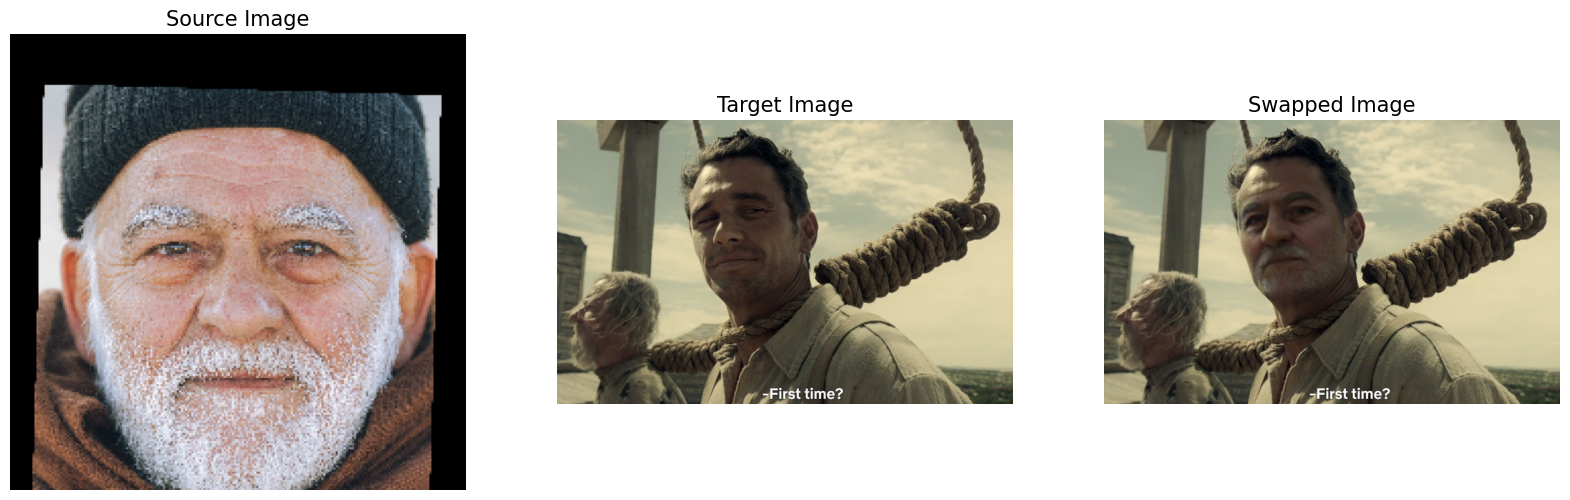

In [1]:
#@markdown #**Preparation**

import cv2
import torch
import time
import os

from utils.inference.image_processing import crop_face, get_final_image, show_images
from utils.inference.video_processing import read_video, get_target, get_final_video, add_audio_from_another_video, face_enhancement
from utils.inference.core import model_inference

from network.AEI_Net import AEI_Net
from insightface_func.face_detect_crop_multi import Face_detect_crop
from arcface_model.iresnet import iresnet100
from models.pix2pix_model import Pix2PixModel
from models.config_sr import TestOptions
import warnings
warnings.filterwarnings("ignore")

#@markdown #**Initialize models**

app = Face_detect_crop(name='antelope', root='./insightface_func/models')
app.prepare(ctx_id= 0, det_thresh=0.6, det_size=(640,640))

# main model for generation
G = AEI_Net(backbone='unet', num_blocks=2, c_id=512)
G.eval()
G.load_state_dict(torch.load('./weights/G_unet_2blocks.pth', map_location=torch.device('cpu')))
# G = G.cuda()
# G = G.half()

# arcface model to get face embedding
netArc = iresnet100(fp16=False)
# netArc = netArc.to(torch.device('cpu'))
netArc.load_state_dict(torch.load('./arcface_model/backbone.pth', map_location=torch.device('cpu')))
# put to cpu
# netArc=netArc.cuda()
netArc.eval()

from coordinate_reg.image_infer import Handler
# # model to get face landmarks
handler = Handler('./coordinate_reg/model/2d106det', 0, ctx_id=0, det_size=640, cpu=True)

# model to make superres of face, set use_sr=True if you want to use super resolution or use_sr=False if you don't
use_sr = False
if use_sr:
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    torch.backends.cudnn.benchmark = True
    opt = TestOptions()
    #opt.which_epoch ='10_7'
    model = Pix2PixModel(opt)
    model.netG.train()
    
#@markdown #**Upload source image and video**

#@markdown choose not really long videos, coz it can take a lot of time otherwise

#@markdown choose source image as a photo -- preferable a selfie of a person

target_type = 'image' #@param ["video", "image"]


file_no = '4'

source_path = f'../../dataset/test/{file_no}.jpg' #@param {type:"string"}
target_path = '../../dataset/first-time.png' #@param {type:"string"}
path_to_video = '' #@param {type:"string"}

source_full = cv2.imread(source_path)
OUT_VIDEO_NAME = "examples/results/result.mp4"
crop_size = 224 # don't change this


# check, if we can detect face on the source image

try:
    source = crop_face(source_full, app, crop_size)[0]
    source = [source[:, :, ::-1]]
    print("Everything is ok!")
except TypeError:
    print("Bad source images")

# read video
if target_type == 'image':
    target_full = cv2.imread(target_path)
    full_frames = [target_full]
else:
    full_frames, fps = read_video(path_to_video)
target = get_target(full_frames, app, crop_size)

#@markdown #**Inference**


batch_size =  100#@param {type:"integer"}

START_TIME = time.time()

final_frames_list, crop_frames_list, full_frames, tfm_array_list = model_inference(full_frames,
                                                                                   source,
                                                                                   target,
                                                                                   netArc,
                                                                                   G,
                                                                                   app,
                                                                                   set_target = False,
                                                                                   crop_size=crop_size,
                                                                                   BS=batch_size)

if use_sr:
    final_frames_list = face_enhancement(final_frames_list, model)

if target_type == 'video':
  get_final_video(final_frames_list,
                  crop_frames_list,
                  full_frames,
                  tfm_array_list,
                  OUT_VIDEO_NAME,
                  fps,
                  handler)

  add_audio_from_another_video(path_to_video, OUT_VIDEO_NAME, "audio")

  print(f'Full pipeline took {time.time() - START_TIME}')
  print(f"Video saved with path {OUT_VIDEO_NAME}")
else:
  result = get_final_image(final_frames_list, crop_frames_list, full_frames[0], tfm_array_list, handler)
  cv2.imwrite(f'examples/results/{file_no}result.png', result)
  
  #@markdown #**Visualize Image to Image swap**

import matplotlib.pyplot as plt

show_images([source[0][:, :, ::-1], target_full, result], ['Source Image', 'Target Image', 'Swapped Image'], figsize=(20, 15))
